In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json
# Import the Class class.
from classy import Class
# Import velocileptors.
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
# Import error function and a spline.
from scipy.special     import erfc
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
from scipy.interpolate import interp1d
# from misc import *
from velocileptors.EPT.ept_fullresum_fftw import REPT
from scipy.interpolate import make_smoothing_spline
from astropy.table import Table, vstack


In [3]:
from matplotlib.pyplot import rc
rc('mathtext', **{'fontset':'cm'})
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [4]:
from pathlib import Path
def read_params(path, keep_headers=True):
    result = {}
    path = Path(path)
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:  continue
            if line.startswith("-log(Like)"):
                if keep_headers:
                    result["-log(Like)"] = float(line.split("=")[1])
                continue
            if line.startswith("chi-sq"):
                if keep_headers:
                    result["chi-sq"] = float(line.split("=")[1])
                continue
            parts = line.split()
            if len(parts) < 3 or not parts[0].isdigit():  continue
            idx, value_str, name = parts[:3]
            value = float(value_str.replace("D", "E").replace("d", "e"))
            result[name] = value
    return result

In [5]:
lae = json.load(open("lae_clustering_c000_ph100_z3.0_s_zcv.json","r"))
params = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 2000,
    'P_k_max_h/Mpc': 50.,
    'z_pk': '0.0,10',
    'lensing': 'yes',
}
for k in ['n_s','omega_b','omega_cdm',\
          'omega_ncdm','N_ncdm','N_ur']:
    print("Setting ",k," = ",lae[k])
    params[k] = lae[k]
params['h'] = lae['H0']/100.0
#
cosmo = Class()
cosmo.set(params)
cosmo.compute()
hub = cosmo.h()

Setting  n_s  =  0.9649
Setting  omega_b  =  0.02237
Setting  omega_cdm  =  0.12
Setting  omega_ncdm  =  0.0006442
Setting  N_ncdm  =  1.0
Setting  N_ur  =  2.0328


In [6]:
# loads the matter shot noise - requires save_matter.py to have been run.
mSN = [1e9/Table.read('matter_AbacusSummit_high_c000_ph100_z2.5.fits')['x'].size,
       1e9/Table.read('matter_AbacusSummit_high_c000_ph100_z3.0.fits')['x'].size]
mSN

[1.3330773842529933, 1.3330773842529933]

In [7]:
def compute_biaspoly(bvec1,bvec2,f,):
    '''
    bvec=(b1,b2,bs,b3 ...,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4), biases are Lagrangian
    '''
    b1a,b2a,bsa,b3a,alpha0a,alpha2a,alpha4a,alpha6a,sna,sn2a,sn4a=bvec1
    b1b,b2b,bsb,b3b,alpha0b,alpha2b,alpha4b,alpha6b,snb,sn2b,sn4b=bvec2
    bE1a = b1a+1
    bE1b = b1b+1
    return np.array([1,(b1a+b1b)/2,b1a*b1b,(b2a+b2b)/2,(b1a*b2b+b1b*b2a)/2,b2a*b2b,(bsa+bsb)/2,(b1a*bsb+b1b*bsa)/2,
                     (b2a*bsb+b2b*bsa)/2,bsa*bsb,(b3a+b3b)/2,(b1a*b3b+b1b*b3a)/2, 
                     (alpha0a*bE1b/bE1a+alpha0b*bE1a/bE1b)/2,
                     (alpha2a*bE1b/bE1a+alpha2b*bE1a/bE1b+alpha0a*f/bE1a*(1-bE1b/bE1a)+alpha0b*f/bE1b*(1-bE1a/bE1b))/2,
                     (alpha4a*bE1b/bE1a+alpha4b*bE1a/bE1b+alpha2a*f/bE1a*(1-bE1b/bE1a)+alpha2b*f/bE1b*(1-bE1a/bE1b)
                     +alpha0a*f**2/bE1a**2*(bE1b/bE1a-1)+alpha0b*f**2/bE1b**2*(bE1a/bE1b-1))/2,
                     0,np.sqrt(sna*snb),np.sqrt(sn2a*sn2b),np.sqrt(sn4a*sn4b)])


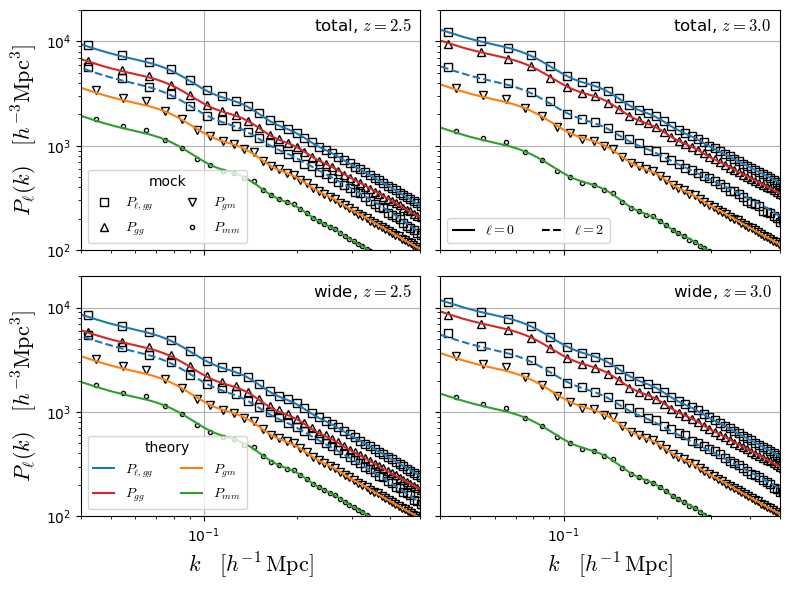

In [9]:
fig,axs = plt.subplots(2,2,figsize=(8,6))
z_list =[2.5,3.]
for j in range(2): # redshift
    zmid = z_list[j]
    f = cosmo.scale_independent_growth_factor_f(zmid)
    k_ = np.geomspace(1e-4,1.,200)
    p_ = np.array( [cosmo.pk(k*hub,zmid)*hub**3 for k in k_] )
    
    lpt = LPT_RSD(k_,p_,kIR=0.2)
    for i in range(2):    # sample
        if i==0: samp_name = 'total'
        else: samp_name = 'bright'
        ax = axs[i,j]
        lae = json.load(open("lae_clustering_c000_ph100_z%.1f_s_zcv.json"%zmid,"r"))
        lae_r = json.load(open("lae_clustering_c000_ph100_z%.1f_r_zcv.json"%zmid,"r"))
        lae_gm = json.load(open("lae_clustering_c000_ph100_z%.1f_r_gm.json"%zmid,"r"))
        lae_mm = json.load(open("lae_clustering_c000_ph100_z%.1f_r_mm.json"%zmid,"r"))
        kk   = np.array(lae['k'])
        samp = lae['mocks'][i]
        true_SN = 1e9/min(samp['nobj'],1e7)
        ax.plot(kk, np.array(samp['pk0']) - true_SN,'s',color='k',mfc='None')
        ax.plot(kk, samp['pk2'],'s' ,color='k',mfc='None')
        kk   = np.array(lae_r['k'])
        samp = lae_r['mocks'][i]
        ax.plot(kk, np.array(samp['pk0']) - true_SN,'^',color='k',mfc='None')
        samp = lae_gm['mocks'][i]
        kk   = np.array(lae_gm['k'])
        ax.plot(kk, samp['pk0'],'v',color='k',mfc='None')
        
        samp = lae_mm['mocks'][0]
        kk   = np.array(lae_mm['k'])
        # ax.plot(kk, samp['pk0'],'.-',color='k',mfc='None')
        ax.plot(kk, np.array(samp['pk0'])-mSN[j],'.',color='k',mfc='None')
        
        lpt.make_pltable(f,kmin=min(k_),kmax=max(k_),nk=len(k_))
    
        varss = read_params('cobaya/output/%s_z%.1f.minimum'%(samp_name,zmid))
        b1, b2, bs, alpha0, alpha2, sn, sn2 = varss['b1'],varss['b2'],varss['bs'],varss['alpha0'],varss['alpha2'],varss['SN0'],varss['SN2']
        pars = [ b1,b2,bs,0,alpha0,alpha2,0,0,sn,sn2,0]
        kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(pars)
        # ax.plot(kv, p0- true_SN,'C0-')
        ax.plot(kv, p0,'C0-')
        ax.plot(kv, p2,'C0--')
        
        lpt.make_pltable(0,kmin=min(k_),kmax=max(k_),nk=len(k_))
        kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(pars)
        # ax.plot(kv, p0- true_SN,'C3-')
        ax.plot(kv, p0,'C3-')
        
        bias = [b1, b2, bs, 0.]
        cterm = [alpha0,alpha2,0,0]
        stoch = [0, 0, 0]
        bvec = bias + cterm + stoch
        
        alpha0_mm = varss['alpha0_mm']
        bias2 = [0, 0,0, 0.]
        cterm2 = [alpha0_mm,0,0,0]
        stoch2 = [0, 0, 0]
        bvec2 = bias2 + cterm2 + stoch2
        
        kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(bvec2)
        ax.plot(kv, p0,'C2-')
        
        bpoly = compute_biaspoly(bvec,bvec2,f)
        # insert new SN parameters
        sn0_gm,sn2_gm =  varss['SN0_gm'],varss['SN2_gm']
        bpoly[-3:] = [sn0_gm,sn2_gm,0]
        
        kv = lpt.kv
        p0 = np.sum(lpt.p0ktable * bpoly,axis=1)
        ax.plot(kv, p0,'C1-')

    
        # ax.set_xlim(1e-2,.5)
        # ax.set_ylim(1e2,3e4)
        ax.set_xlim(4e-2,.5)
        ax.set_ylim(1e2,2e4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        if j==0:
            ax.set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=16)
            # ax.set_ylabel(r'$P(k)\quad [h^{-2}{\rm Mpc}^2]$',fontsize=16)
            if i==0:
                ax.plot([],[],'ks',label = r'$P_{\ell,gg}$',mfc='none')
                ax.plot([],[],'k^',label = r'$P_{gg}$',mfc='none')
                ax.plot([],[],'kv',label = r'$P_{gm}$',mfc='none')
                ax.plot([],[],'k.',label = r'$P_{mm}$',mfc='none')
                ax.legend(handlelength=1.5,loc='lower left',title='mock',ncol=2)
            else:
                ax.plot([],[],'C0',label = r'$P_{\ell,gg}$')
                ax.plot([],[],'C3',label = r'$P_{gg}$')
                ax.plot([],[],'C1',label = r'$P_{gm}$')
                ax.plot([],[],'C2',label = r'$P_{mm}$')
                ax.legend(ncol=2,handlelength=1.5,loc='lower left',title='theory',)
        else: 
            if i==1: print()
            else: 
                ax.plot([],[],'k-',label = r'$\ell=0$')
                ax.plot([],[],'k--',label = r'$\ell=2$')
                ax.legend(ncol=2,handlelength=1.5,loc='lower left')
            ax.set_yticklabels([])

        if samp_name=='total':ax.set_title(r'%s, $z=%.1f$'%(samp_name,zmid),y=.88,x=.83)
        else: ax.set_title(r'wide, $z=%.1f$'%(zmid),y=.88,x=.83)
        if i==1:  ax.set_xlabel(r'$k\quad [h^{-1}\,{\rm Mpc}]$',fontsize=16)
        else:  ax.set_xticklabels([])
        ax.grid()
fig.tight_layout()
# plt.savefig('plots/zcv_fit.pdf')

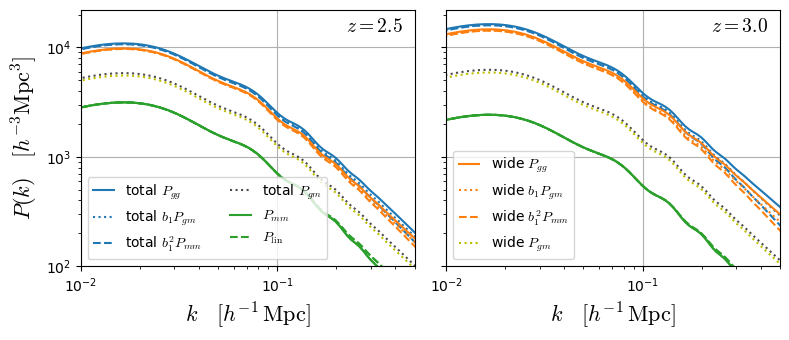

In [10]:
fig,axs = plt.subplots(1,2,figsize=(8,3.5))
z_list =[2.5,3.]
for j in range(2): # redshift
    zmid = z_list[j]
    f = cosmo.scale_independent_growth_factor_f(zmid)
    k_ = np.geomspace(1e-4,1.,200)
    p_ = np.array( [cosmo.pk(k*hub,zmid)*hub**3 for k in k_] )
    
    lpt = LPT_RSD(k_,p_,kIR=0.2)
    for i in range(2):    # sample
        if i==0: samp_name = 'total'
        else: samp_name = 'bright'
        ax = axs[j]
        lae = json.load(open("lae_clustering_c000_ph100_z%.1f_s_zcv.json"%zmid,"r"))
        samp = lae['mocks'][i]
        true_SN = 1e9/min(samp['nobj'],1e7)

        varss = read_params('cobaya/output/%s_z%.1f.minimum'%(samp_name,zmid))
        b1, b2, bs, alpha0, alpha2, sn, sn2 = varss['b1'],varss['b2'],varss['bs'],varss['alpha0'],varss['alpha2'],varss['SN0'],varss['SN2']
        pars = [ b1,b2,bs,0,alpha0,alpha2,0,0,sn,sn2,0]
        
        lpt.make_pltable(0,kmin=min(k_),kmax=max(k_),nk=len(k_))
        kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(pars)
        # ax.plot(kv, p0- true_SN,'C%d-'%i)
        ax.plot(kv, p0,'C%d-'%i)
        # ax.plot(k_, p_ * (b1+1)**2, 'C%d--'%i)
        
        bias = [b1, b2, bs, 0.]
        cterm = [alpha0,alpha2,0,0]
        stoch = [0, 0, 0]
        bvec = bias + cterm + stoch
        
        alpha0_mm = varss['alpha0_mm']
        bias2 = [0, 0,0, 0.]
        cterm2 = [alpha0_mm,0,0,0]
        stoch2 = [0, 0, 0]
        bvec2 = bias2 + cterm2 + stoch2
        
        kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(bvec2)
        p0 -= mSN[j]
        ax.plot(kv, p0,'C2--')
        ax.plot(k_, p_,'C2-')
        ax.plot(kv, p0 * (b1+1)**2, 'C%d--'%i)
        
        bpoly = compute_biaspoly(bvec,bvec2,f)
        # insert new SN parameters
        sn0_gm,sn2_gm =  varss['SN0_gm'],varss['SN2_gm']
        bpoly[-3:] = [sn0_gm,sn2_gm,0]
        
        kv = lpt.kv
        p0 = np.sum(lpt.p0ktable * bpoly,axis=1)
        if i==0:ax.plot(kv, p0,'k:',alpha=.7)
        else: ax.plot(kv, p0,'y:',)
        ax.plot(kv, p0*(b1+1),'C%d:'%i)
    ax.set_xlim(1e-2,.5)
    ax.set_ylim(1e2,2.2e4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if j==0:
        ax.set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=16)
        ax.set_ylabel(r'$P(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=16)
        ax.plot([],[],'C0-',label = r'total $P_{gg}$')
        ax.plot([],[],'C0:',label = r'total $b_1 P_{gm}$')
        ax.plot([],[],'C0--',label = r'total $b_1^2 P_{mm}$')
        ax.plot([],[],'k:',label = r'total $P_{gm}$',alpha=.7)
        ax.plot([],[],'C2-',label = r'$P_{mm}$')
        ax.plot([],[],'C2--',label = r'$P_{\rm lin}$')
        ax.legend(ncol=2,handlelength=1.5,loc='lower left')
    else: 
        ax.set_yticklabels([])
        ax.plot([],[],'C1-',label = r'wide $P_{gg}$')
        ax.plot([],[],'C1:',label = r'wide $b_1 P_{gm}$')
        ax.plot([],[],'C1--',label = r'wide $b_1^2 P_{mm}$')
        ax.plot([],[],'y:',label = r'wide $P_{gm}$',)
        ax.legend(handlelength=1.5,loc='lower left')

    ax.set_title(r'$z=%.1f$'%(zmid),y=.88,x=.88,fontsize=14)
    ax.set_xlabel(r'$k\quad [h^{-1}\,{\rm Mpc}]$',fontsize=16)
    ax.grid()
fig.tight_layout()
# fig.savefig('plots/Pgg.pdf')
fig.show()

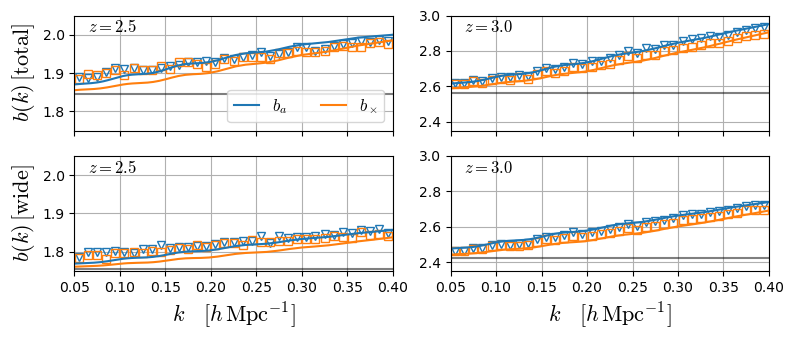

In [14]:
fig,axs = plt.subplots(2,2,figsize=(8,3.5))

line_styles = ['-','-']
sample_names = ['total','bright']
z_list = [2.5,3.]
for j in range(2):
    zmid = z_list[j]
    
    # sim
    lae = json.load(open("lae_clustering_c000_ph100_z%.1f_r.json"%zmid,"r"))
    lae_gm = json.load(open("lae_clustering_c000_ph100_z%.1f_r_gm.json"%zmid,"r"))
    lae_mm = json.load(open("lae_clustering_c000_ph100_z%.1f_r_mm.json"%zmid,"r"))
    samp = lae_mm['mocks'][0]
    kv = np.array(lae_mm['k'])
    p0 = np.array(samp['pk0'])#  - 1e9/8e6
    p0 -= mSN[j]
    for i in range(2):
        kk = np.array(lae['k'])
        samp = lae['mocks'][i]
        sim_pk0 = np.array(samp['pk0'])-1e9/min(samp['nobj'],1e7)
        axs[i,j].plot(kk, np.sqrt(sim_pk0/interp1d(kv, p0,fill_value='extrapolate')(kk)),'C%dv'%(0),mfc='None')
    
        samp = lae_gm['mocks'][i]
        kk = np.array(lae_gm['k'])
        axs[i,j].plot(kk, (samp['pk0']/interp1d(kv, p0,fill_value='extrapolate')(kk)),'C%ds'%(1),mfc='None')
        
for j in range(2):
    zmid = z_list[j]
    k_ = np.geomspace(1e-4,1.,200)
    p_ = np.array( [cosmo.pk_cb_lin(k*hub,zmid)*hub**3 for k in k_] )
    lpt = LPT_RSD(k_,p_,kIR=0.2)
    lpt.make_pltable(0,kmin=min(k_),kmax=max(k_),nk=len(k_))

    pars = [ 0,0,0,0,0,0,0,0,0,0,0 ]
    
    lae = json.load(open("lae_clustering_c000_ph100_z%.1f_r.json"%zmid,"r"))
    # analytical
    for i in range(2):
        samp = lae['mocks'][i]
        varss = read_params('cobaya/output/%s_z%.1f.minimum'%(sample_names[i],zmid))

        alpha0_mm = varss['alpha0_mm']
        bias2 = [0, 0,0, 0.];    cterm2 = [alpha0_mm,0,0,0];    stoch2 = [0, 0, 0]
        bvec2 = bias2 + cterm2 + stoch2
        kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(bvec2)
        
        b1, b2, bs, alpha0, alpha2, sn, sn2 = varss['b1'],varss['b2'],varss['bs'],varss['alpha0'],varss['alpha2'],varss['SN0'],varss['SN2']
        pars = [ b1,b2,bs,0,alpha0,alpha2,0,0,sn,sn2,0]
        kv_, p0_, _, _ = lpt.combine_bias_terms_pkell(pars)
        axs[i,j].plot(kv_, np.sqrt(p0_/interp1d(kv, p0,fill_value='extrapolate')(kv_)),'C%d'%(0)+line_styles[i],)

        bias = [b1, b2, bs, 0.];    cterm = [alpha0,alpha2,0,0];    stoch = [0, 0, 0]
        bvec = bias + cterm + stoch
        
        alpha0_mm = varss['alpha0_mm']
        bias2 = [0, 0,0, 0.];    cterm2 = [alpha0_mm,0,0,0];    stoch2 = [0, 0, 0]
        bvec2 = bias2 + cterm2 + stoch2
             
        bpoly = compute_biaspoly(bvec,bvec2,cosmo.scale_independent_growth_factor_f(zmid))
        sn0_gm,sn2_gm =  varss['SN0_gm'],varss['SN2_gm']
        bpoly[-3:] = [sn0_gm,sn2_gm,0]
        
        p0_ = np.sum(lpt.p0ktable * bpoly,axis=1)
        kv_ = lpt.kv
        axs[i,j].plot(kv_, p0_/interp1d(kv, p0,fill_value='extrapolate')(kv_),'C%d'%(1)+line_styles[i],)
        axs[i,j].axhline(b1+1,c='k',ls=line_styles[i],alpha=.5)

axs[0,0].plot([],[],'C0',label=r'$b_a$')
axs[0,0].plot([],[],'C1',label=r'$b_\times$')
axs[0,0].legend(fontsize=12,ncol=2,handlelength=1.5,loc='lower right')

axs[0,0].set_ylim(1.75,2.05)
axs[0,1].set_ylim(2.35,3.0)
axs[1,0].set_ylim(1.75,2.05)
axs[1,1].set_ylim(2.35,3.0)

for j in range(2):
    for i in range(2):
        ax = axs[i,j]
        if j==0:
            if i==0: ax.set_ylabel(r'$b(k)\,[\text{total}]$',fontsize=16)
            else: ax.set_ylabel(r'$b(k)\,[\text{wide}]$',fontsize=16)
        if i==1:
            ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=16)
        else: 
            ax.set_xticklabels([])
        ax.set_xlim(5e-2,.4)
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        ax.set_title(r'$z=%.1f$'%z_list[j],y=.78,x=.12)
        ax.grid()
fig.tight_layout()
# fig.savefig('plots/scale_dependent_bias.pdf')
fig.show()

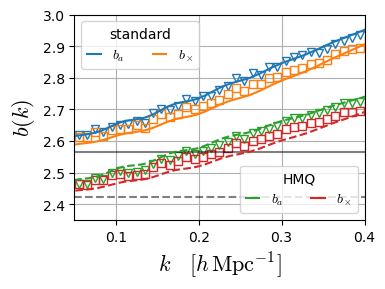

In [25]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

line_styles = ['-','--']
sample_names = ['total','bright']
z_list = [2.5,3.]
j = 1 # choose z
zmid = z_list[j]

# sim
lae = json.load(open("lae_clustering_c000_ph100_z%.1f_r.json"%zmid,"r"))
lae_gm = json.load(open("lae_clustering_c000_ph100_z%.1f_r_gm.json"%zmid,"r"))
lae_mm = json.load(open("lae_clustering_c000_ph100_z%.1f_r_mm.json"%zmid,"r"))
samp = lae_mm['mocks'][0]
kv = np.array(lae_mm['k'])
p0 = np.array(samp['pk0'])#  - 1e9/8e6
p0 -= mSN[j]
for i in range(2):
    kk = np.array(lae['k'])
    samp = lae['mocks'][i]
    sim_pk0 = np.array(samp['pk0'])-1e9/min(samp['nobj'],1e7)
    ax.plot(kk, np.sqrt(sim_pk0/interp1d(kv, p0,fill_value='extrapolate')(kk)),'C%dv'%(i*2),mfc='None')

    samp = lae_gm['mocks'][i]
    kk = np.array(lae_gm['k'])
    ax.plot(kk, (samp['pk0']/interp1d(kv, p0,fill_value='extrapolate')(kk)),'C%ds'%(i*2+1),mfc='None')
        
zmid = z_list[j]
k_ = np.geomspace(1e-4,1.,200)
p_ = np.array( [cosmo.pk_cb_lin(k*hub,zmid)*hub**3 for k in k_] )
lpt = LPT_RSD(k_,p_,kIR=0.2)
lpt.make_pltable(0,kmin=min(k_),kmax=max(k_),nk=len(k_))

pars = [ 0,0,0,0,0,0,0,0,0,0,0 ]

lae = json.load(open("lae_clustering_c000_ph100_z%.1f_r.json"%zmid,"r"))
# analytical
for i in range(2):
    samp = lae['mocks'][i]
    varss = read_params('cobaya/output/%s_z%.1f.minimum'%(sample_names[i],zmid))

    alpha0_mm = varss['alpha0_mm']
    bias2 = [0, 0,0, 0.];    cterm2 = [alpha0_mm,0,0,0];    stoch2 = [0, 0, 0]
    bvec2 = bias2 + cterm2 + stoch2
    kv, p0, p2, p4 = lpt.combine_bias_terms_pkell(bvec2)
    # p0 -= mSN[j]
    
    b1, b2, bs, alpha0, alpha2, sn, sn2 = varss['b1'],varss['b2'],varss['bs'],varss['alpha0'],varss['alpha2'],varss['SN0'],varss['SN2']
    pars = [ b1,b2,bs,0,alpha0,alpha2,0,0,sn,sn2,0]
    kv_, p0_, _, _ = lpt.combine_bias_terms_pkell(pars)
    # p0_ -= 1e9/min(samp['nobj'],1e7)
    # axs[j].plot(kv_, np.sqrt(p0_/interp1d(kv, p0,fill_value='extrapolate')(kv_)),line_styles[i],color='C3',mfc='None')
    ax.plot(kv_, np.sqrt(p0_/interp1d(kv, p0,fill_value='extrapolate')(kv_)),'C%d'%(i*2)+line_styles[i],)

    bias = [b1, b2, bs, 0.];    cterm = [alpha0,alpha2,0,0];    stoch = [0, 0, 0]
    bvec = bias + cterm + stoch
    
    alpha0_mm = varss['alpha0_mm']
    bias2 = [0, 0,0, 0.];    cterm2 = [alpha0_mm,0,0,0];    stoch2 = [0, 0, 0]
    bvec2 = bias2 + cterm2 + stoch2
            
    bpoly = compute_biaspoly(bvec,bvec2,cosmo.scale_independent_growth_factor_f(zmid))
    sn0_gm,sn2_gm =  varss['SN0_gm'],varss['SN2_gm']
    bpoly[-3:] = [sn0_gm,sn2_gm,0]
    
    p0_ = np.sum(lpt.p0ktable * bpoly,axis=1)
    kv_ = lpt.kv
    ax.plot(kv_, p0_/interp1d(kv, p0,fill_value='extrapolate')(kv_),'C%d'%(i*2+1)+line_styles[i],)
    ax.axhline(b1+1,c='k',ls=line_styles[i],alpha=.5)

l0, = ax.plot([],[],'C0',label=r'$b_a$')
l1, = ax.plot([],[],'C1',label=r'$b_\times$')
l2, = ax.plot([],[],'C2',label=r'$b_a$')
l3, = ax.plot([],[],'C3',label=r'$b_\times$')

legend1 = ax.legend(handles=[l0,l1], loc='upper left',frameon=True,handlelength=1,ncol=2,title='standard')
# legend1.get_texts()[1].set_fontweight('bold')
ax.add_artist(legend1)  

# Second legend (for dashed lines)
legend2 = ax.legend(handles=[l2,l3], loc='lower right',frameon=True,handlelength=1,ncol=2,title='HMQ')

ax.set_ylabel(r'$b(k)$',fontsize=16)
ax.set_ylim(2.35,3.0)
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=16)
ax.set_xlim(0.05,.4)
ax.grid()
fig.tight_layout()
# fig.savefig('plots/scale_dependent_bias.pdf')
fig.show()